In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from tqdm import tqdm

from IPython.display import clear_output

import torch
import torch.multiprocessing as mp
import torch.nn.functional as F
from torch.utils.data import ConcatDataset

PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_DIR)

# from visualize_geo_dist import load_geo_dist
from dataloader.dataloader import CamLocDataset
from dataloader.dataloader_supercon import CamLocDatasetSupercon
from utils import get_unique_file_name

In [2]:
# Recap on raw data structure
coords = torch.load(os.path.join(PROJECT_DIR, 'datasets/EPFL/test_real/init/EPFL_2020-09-17-piloted_00035_DJI_0067.dat'))
print("Coordinate raw data shape {}".format(coords.shape))

depth = torch.load(os.path.join(PROJECT_DIR, 'datasets/EPFL/test_real/depth/EPFL_2020-09-17-piloted_00035_DJI_0067.dat'))
print("Depth raw data shape {}".format(depth.shape))

normal = torch.load(os.path.join(PROJECT_DIR, 'datasets/EPFL/test_real/normal/EPFL_2020-09-17-piloted_00035_DJI_0067.dat'))
print("Normal raw data shape {}".format(normal.shape))

Coordinate raw data shape torch.Size([3, 60, 90])
Depth raw data shape torch.Size([60, 90])
Normal raw data shape torch.Size([3, 60, 90])


# Contrastive sampling dataloader

In [ ]:
top_n = 6
scene = 'EPFL'

trainset_supercon = CamLocDatasetSupercon(root_dir_sim=os.path.join(PROJECT_DIR, "datasets", scene, "train_sim_aug"),
                                          root_dir_real=os.path.join(PROJECT_DIR, "datasets", scene, "train_real"),
                                          coord=True, depth=True, normal=True, augment=True, raw_image=False,
                                          supercon=True, sampling_cross_dom_pos_min=3,
                                          sampling_cross_dom_pos_top_n=5,
                                          sampling_in_dom_pos_top_n=5,
                                          sampling_cross_dom_neg_top_n=5,
                                          sampling_in_dom_neg_top_n=5)
# trainset_loader = torch.utils.data.DataLoader(trainset_supercon, shuffle=True, num_workers=mp.cpu_count(),
#                                               pin_memory=True, collate_fn=trainset_supercon.batch_resize)
trainset_loader = torch.utils.data.DataLoader(trainset_supercon, shuffle=True, num_workers=mp.cpu_count(),
                                              pin_memory=True, batch_size=1)

In [ ]:
len(trainset_supercon)

In [ ]:
def load_geo_dist(scene):
    """
    Load pre-computed geometric distance table.
    """
    geo_dist_path = os.path.abspath(os.path.join(PROJECT_DIR, "datasets", scene, 'geo_dist.dat'))
    assert os.path.exists(geo_dist_path)
    print('Load geometric distance from {:s}...'.format(geo_dist_path))
    geo_dist_dict = torch.load(geo_dist_path)
    # geo_dist = geo_dist_dict['geo_dist'].cuda()  # raw distance table, debug purpose
    sim_data = geo_dist_dict['sim_data'].cuda()
    dict_name_to_idx = geo_dist_dict['dict_name_to_idx']
    dict_idx_to_name = geo_dist_dict['dict_idx_to_name']
    hyper_params = geo_dist_dict['hyper_params']
    dict_supercon = geo_dist_dict['dict_supercon']
#     dict_ranking = geo_dist_dict['dict_ranking']  # raw ranking dict, debug purpose
    feasible_anchor = geo_dist_dict['feasible_anchor']
#     rot_dist = geo_dist_dict['rot_dist']
    trans_dist = geo_dist_dict['trans_dist']

    return sim_data, dict_name_to_idx, dict_idx_to_name, hyper_params, dict_supercon, feasible_anchor, trans_dist

In [ ]:
# read geo distance table
sim_data, dict_name_to_idx, dict_idx_to_name, hyper_params, dict_supercon, feasible_anchor, trans_dist = load_geo_dist(scene)
print('%d / %d samples are feasible anchors after pre-screening.' % (len(feasible_anchor), len(sim_data)))

# check the simple concatenation of sim-real data
sim_size = sim_data.sum().item()
for i in range(len(sim_data)):
    if i < sim_size:
        assert sim_data[i]
    else:
        assert ~sim_data[i]
real_size = len(sim_data) - sim_size

In [ ]:
"""Check data instance rollout one by one"""
torch.cuda.empty_cache()

data_rollout = [0] * len(trainset_loader)

for idx, (masks, images, gt_poses, gt_coords, focal_lengths, file_names) in enumerate(trainset_loader):

    masks = masks.clone().view(-1)
    file_names = np.asarray(file_names).reshape(-1)
    print('\rData instance no. {:d}, totally visited data: {:d}'.format(idx, int(np.sum(data_rollout))), end=" ", flush=True)

    for mask, file_name in zip(masks, file_names):
        if mask:
            true_idx = dict_name_to_idx[get_unique_file_name(file_name)]
            data_rollout[true_idx] += 1

data_rollout = np.array(data_rollout)
np.save('data_rollout_new.npy', data_rollout)

In [ ]:
trans_dist = trans_dist.cpu().numpy()

In [ ]:
def _invert_permutation(P):
    """
    Invert the permutation P
    @param P: [B, N] matrix for B permutations in range of [0, 1, ..., N-1]
    Return the inversion of the permutation, which is esentially np.argsort(P, axis=1) but FASTER.
    """
    B, N = P.shape
    inv = np.empty_like(P)
    idx_rows = np.concatenate([[i] * N for i in range(B)])
    idx_cols = P.ravel()
    inv[idx_rows, idx_cols] = np.concatenate([np.arange(N)] * B)
    return inv
    

In [ ]:
time_elapsed = []
time_argsort = []
for _ in range(100):
    A = np.stack([np.random.permutation(np.arange(200)) for _ in range(15000)])
    time_start = time.time()
    inv_ = _invert_permutation(A)
    time_elapsed.append(time.time() - time_start)
    
    time_start = time.time()
    inv__ = np.argsort(A, axis=1)
    time_argsort.append(time.time() - time_start)
    
    assert np.sum(inv_ - inv__) == 0

print("Fast alg.: {:.2f}ms, ARGSORT alg.: {:.2f}ms".format(np.mean(time_elapsed), np.mean(time_argsort)))

In [ ]:
trans_dist[0][0:10]

In [ ]:
def check_backward_ranking(sample_ranking, anchor_id, k_percentage, reverse=False):
    """
    Check backward ranking/re-ranking constraint.
    """
    if isinstance(sample_ranking, list) and isinstance(sample_ranking[0], np.ndarray):
        sample_ranking_cat = np.stack(sample_ranking, axis=0)  # [B, N]
        if reverse:
            sample_ranking_cat = sample_ranking_cat[:, ::-1]        
        b_rank_rows, backward_rank_ls = np.where(sample_ranking_cat == anchor_id)
        assert np.array_equal(np.sort(b_rank_rows), np.arange(sample_ranking_cat.shape[0])), print(b_rank_rows)  # sanity check, anchor_id should appear in each row once and only once
        critical_backward_rank = np.ceil(sample_ranking_cat.shape[1] * k_percentage).astype('int')
        return backward_rank_ls < critical_backward_rank  # [B, ]
    elif isinstance(sample_ranking, np.ndarray):
        assert anchor_id in sample_ranking  # sanity check
        if reverse:
            sample_ranking = sample_ranking[::-1]
        backward_rank = int(np.where(sample_ranking == anchor_id)[0])  # reciprocal rank of anchor seen from sample
        critical_backward_rank = np.ceil(len(sample_ranking) * k_percentage).astype('int')  # top/bottom k% re-ranking
        return backward_rank < critical_backward_rank  # scalar
    else:
        raise NotImplementedError
            
            
def _backbone_trim_ranking(dict_ranking, trans_dist, pos_forward_ranking, pos_backward_ranking, pos_max_trans, 
                           neg_forward_ranking, neg_backward_ranking,
                           dict_supercon, i_anchor, feasible_anchor, mp_progress, mp_lock):
    
#     print("\rProgress: {:d} / {:d}".format(mp_progress.value, len(dict_ranking)), flush=True, end=' ')
    print("Progress: {:d} / {:d}".format(mp_progress.value, len(dict_ranking)), flush=True)
    
#     # store top k% in-domain positives with re-ranking
#     in_dom_positives_cand = dict_ranking[i_anchor]['same']
#     in_dom_positives_cand = in_dom_positives_cand[:np.ceil(pos_forward_ranking * len(in_dom_positives_cand)).astype('int')]
#     flag_re_ranking = check_backward_ranking([dict_ranking[i_sample]['same'] for i_sample in in_dom_positives_cand], i_anchor, pos_backward_ranking)
#     flag_pos_max_trans = np.take(trans_dist[i_anchor].copy(), in_dom_positives_cand) < pos_max_trans
#     in_dom_positives = in_dom_positives_cand[np.logical_and(flag_re_ranking, flag_pos_max_trans)]  # to save

#     # store top k% cross-domain positives with re-ranking
#     cross_dom_pos_cand = dict_ranking[i_anchor]['diff']
#     cross_dom_pos_cand = cross_dom_pos_cand[:np.ceil(pos_forward_ranking * len(cross_dom_pos_cand)).astype('int')]
#     flag_re_ranking = check_backward_ranking([dict_ranking[i_sample]['diff'] for i_sample in cross_dom_pos_cand], i_anchor, pos_backward_ranking)
#     flag_pos_max_trans = np.take(trans_dist[i_anchor].copy(), cross_dom_pos_cand) < pos_max_trans
#     cross_dom_positives = cross_dom_pos_cand[np.logical_and(flag_re_ranking, flag_pos_max_trans)]  # to save

#     # store bottom k% in-domain negatives with re-ranking
#     in_dom_negatives_cand = dict_ranking[i_anchor]['same']
#     in_dom_negatives_cand = in_dom_negatives_cand[-np.ceil(neg_forward_ranking * len(in_dom_negatives_cand)).astype('int'):]
#     flag_re_ranking = check_backward_ranking([dict_ranking[i_sample]['same'] for i_sample in in_dom_negatives_cand], i_anchor, neg_backward_ranking, reverse=True)
#     in_dom_negatives = in_dom_negatives_cand[flag_re_ranking]  # to save

#     # store bottom k% cross-domain negatives with re-ranking
#     cross_dom_negatives_cand = dict_ranking[i_anchor]['diff']
#     cross_dom_negatives_cand = cross_dom_negatives_cand[-np.ceil(neg_forward_ranking * len(cross_dom_negatives_cand)).astype('int'):]
#     flag_re_ranking = check_backward_ranking([dict_ranking[i_sample]['diff'] for i_sample in cross_dom_negatives_cand], i_anchor, neg_backward_ranking, reverse=True)
#     cross_dom_negatives = cross_dom_negatives_cand[flag_re_ranking]  # to save

#     # aggregate into a dict
#     dict_anchor = {
#         "positive": {"same": in_dom_positives, "diff": cross_dom_positives},
#         "negative": {"same": in_dom_negatives, "diff": cross_dom_negatives}
#     }
#     dict_supercon[i_anchor] = dict_anchor
    
#     if len(cross_dom_positives) > 0:
#         feasible_anchor.append(i_anchor)

#     with mp_lock:
#         mp_progress.value += 1
    
    
import multiprocessing as mp
    
def trim_ranking(dict_ranking, trans_dist, pos_forward_ranking, pos_backward_ranking, pos_max_trans, neg_forward_ranking, neg_backward_ranking):
    """
    Thresholding to get feasible anchors and the associated prescreened positives and negatives.
    """
    
#     dict_supercon = {}
#     feasible_anchor = []
    
    mp_manager = mp.Manager()
    mp_feasible_anchor = mp_manager.list()
    mp_dict_supercon = mp_manager.list()
    mp_progress = mp_manager.Value('i', 0)
    mp_lock = mp_manager.Lock()
    for _ in range(len(dict_ranking)):
        mp_feasible_anchor.append(None)
        mp_dict_supercon.append(None)
    
    mp_func_args_ls = []
    for i_anchor in tqdm(range(len(dict_ranking)), desc='Sample thresholding based on reciprocal rank: O(n)'):
        mp_func_args_ls.append((dict_ranking, trans_dist, pos_forward_ranking, pos_backward_ranking, pos_max_trans, 
                                neg_forward_ranking, neg_backward_ranking,
                                dict_supercon, i_anchor, feasible_anchor, mp_progress, mp_lock))

#         # store top k% in-domain positives with re-ranking
#         in_dom_positives_cand = dict_ranking[i_anchor]['same']
#         in_dom_positives_cand = in_dom_positives_cand[:np.ceil(pos_forward_ranking * len(in_dom_positives_cand)).astype('int')]
#         flag_re_ranking = check_backward_ranking([dict_ranking[i_sample]['same'] for i_sample in in_dom_positives_cand], i_anchor, pos_backward_ranking)
#         flag_pos_max_trans = np.take(trans_dist[i_anchor].copy(), in_dom_positives_cand) < pos_max_trans
#         in_dom_positives = in_dom_positives_cand[np.logical_and(flag_re_ranking, flag_pos_max_trans)]  # to save

#         # store top k% cross-domain positives with re-ranking
#         cross_dom_pos_cand = dict_ranking[i_anchor]['diff']
#         cross_dom_pos_cand = cross_dom_pos_cand[:np.ceil(pos_forward_ranking * len(cross_dom_pos_cand)).astype('int')]
#         flag_re_ranking = check_backward_ranking([dict_ranking[i_sample]['diff'] for i_sample in cross_dom_pos_cand], i_anchor, pos_backward_ranking)
#         flag_pos_max_trans = np.take(trans_dist[i_anchor].copy(), cross_dom_pos_cand) < pos_max_trans
#         cross_dom_positives = cross_dom_pos_cand[np.logical_and(flag_re_ranking, flag_pos_max_trans)]  # to save

#         # store bottom k% in-domain negatives with re-ranking
#         in_dom_negatives_cand = dict_ranking[i_anchor]['same']
#         in_dom_negatives_cand = in_dom_negatives_cand[-np.ceil(neg_forward_ranking * len(in_dom_negatives_cand)).astype('int'):]
#         flag_re_ranking = check_backward_ranking([dict_ranking[i_sample]['same'] for i_sample in in_dom_negatives_cand], i_anchor, neg_backward_ranking, reverse=True)
#         in_dom_negatives = in_dom_negatives_cand[flag_re_ranking]  # to save

#         # store bottom k% cross-domain negatives with re-ranking
#         cross_dom_negatives_cand = dict_ranking[i_anchor]['diff']
#         cross_dom_negatives_cand = cross_dom_negatives_cand[-np.ceil(neg_forward_ranking * len(cross_dom_negatives_cand)).astype('int'):]
#         flag_re_ranking = check_backward_ranking([dict_ranking[i_sample]['diff'] for i_sample in cross_dom_negatives_cand], i_anchor, neg_backward_ranking, reverse=True)
#         cross_dom_negatives = cross_dom_negatives_cand[flag_re_ranking]  # to save
        
#         dict_anchor = {
#             "positive": {"same": in_dom_positives, "diff": cross_dom_positives},
#             "negative": {"same": in_dom_negatives, "diff": cross_dom_negatives}
#         }
#         dict_supercon[i_anchor] = dict_anchor

#         if len(cross_dom_positives) > 0:
#             feasible_anchor.append(i_anchor)

    with mp.Pool() as p:
        p.starmap(_backbone_trim_ranking, mp_func_args_ls, chunksize=os.cpu_count()//2)


    return dict_supercon, feasible_anchor

In [ ]:
z = [9187, 3007, 3582, 13017, 8718, 739, 1512, 11388, 667, 3533, 11931, 12457, 3404, 6788, 11798, 11109, 8219, 11444, 5075, 3514, 8188, 10971, 2643, 1243, 7173, 3536, 8451, 6238, 2057, 7562, 3037, 13011, 7492, 7144, 3797, 3337, 6523, 8924, 12578, 636, 7969, 8892, 9193, 562, 11572, 4116, 7028, 10205, 2629, 2789, 12384, 12162, 769, 6616, 1594, 740, 9548, 11834, 11110, 12354, 6688, 9575, 4208, 6963, 445, 5514, 12409, 11878, 2501, 5556, 5001, 12069, 6739, 6733, 9799, 11643, 11318, 11377, 4279, 3642, 5852, 5115, 718, 2817, 7558, 15220, 8230, 4247, 264, 13370, 3809, 5676, 9828, 11306, 5694, 13324, 11081, 5593, 14968, 3195, 11294, 2808, 11514, 6805, 40, 8498, 8169, 6290, 911, 6368, 8276, 374, 12092, 2986, 10716, 5319, 8454, 4305, 10591, 1728, 9637, 14969, 652, 2586, 10096, 5599, 10906, 14176, 1907, 12178, 184, 12428, 15221, 424, 10544, 3243, 8467, 1938, 3019, 12616, 6351, 3177, 13160, 12430, 3046, 3756, 4253, 1894, 3713, 1987, 7410, 3986, 5031]
print(z)

In [ ]:
new_dict_supercon, new_feasible_anchor = trim_ranking(dict_ranking, trans_dist, pos_max_trans=150,
                                                      pos_forward_ranking=0.01, pos_backward_ranking=0.05, 
                                                      neg_forward_ranking=0.05, neg_backward_ranking=0.05)
print("Number of feasible anchors: {:d} / {:d}".format(len(new_feasible_anchor), len(dict_ranking)))
print('Distribution: {:d} / {:d} synthetic anchors, {:d} / {:d} real anchors.'.format(np.sum(np.asarray(new_feasible_anchor) < sim_size),
                                                                                      sim_size,
                                                                                      np.sum(np.asarray(new_feasible_anchor) >= sim_size),
                                                                                      real_size))

In [ ]:
os.getcwd()

In [ ]:
# data_rollout = np.load(os.path.join(PROJ_DIR, 'datasets/EPFL/data_rollout.npy'))

# data_rollout = np.load(os.path.join(os.getcwd(), '../data_rollout_new.npy'))
data_rollout = np.load(os.path.join(os.getcwd(), '../data_weight.npy'))
data_rollout_ideal = np.array([np.sum(data_rollout) / len(data_rollout)] * len(data_rollout))
data_rollout

In [ ]:
plt.plot(data_rollout)
plt.savefig("data_rollout_new.png")

In [ ]:
weights = np.min(data_rollout) / data_rollout

In [ ]:
np.min(weights)

In [ ]:
data_rollout_ideal

In [ ]:
plt.figure(figsize=(10, 6))
_ = plt.hist(data_rollout, bins=500, density=True, cumulative=True, label='Actual')
_ = plt.hist(data_rollout_ideal, bins=500, density=True, cumulative=True, label='Ideal')
plt.xlabel("#visiting per epoch")
# plt.ylabel("#datapoints")
plt.ylabel("Cumulative probability")
plt.xlim([0, 100])
plt.legend()

In [ ]:
plt.figure(figsize=(10, 6))
_ = plt.hist(data_rollout, bins=100, label='Actual')
_ = plt.hist(data_rollout_ideal, bins=1, label='Ideal')
plt.xlabel("#visiting per epoch")
plt.ylabel("#datapoints")
plt.xlim([0, 100])
plt.legend()

In [ ]:
# A comparison of for-loop interpolation and batch interpolation
# For loop sucks.

bs = 8
test_times = 50

# Interpolate via for-loop
time_for = []
for _ in range (test_times):
    z = torch.rand([bs, 3, 480, 720])
    time_start = time.time()
    z_for = [F.interpolate(item.unsqueeze(0), (item.size(1) // 3, item.size(2) // 3))[0] for item in z]
    z_for = torch.stack(z_for, dim=0)
    time_for.append(time.time() - time_start)
print("For loop AVG time: {:.2f}ms".format(np.mean(time_for)*1e3))

# Interpolate in a batch
time_batch = []
for _ in range(test_times):
    z = torch.rand([bs, 3, 480, 720])
    time_start = time.time()
    z_batch = F.interpolate(z, (z.size(2) // 3, z.size(3) // 3))
    time_batch.append(time.time() - time_start)
print("Batch loop AVG time: {:.2f}ms".format(np.mean(time_batch)*1e3)) 


# Vanilla dataloader w/o contrastive sampling

In [4]:
# Minimum sample for how the VANILLA dataloader should be called

trainset = CamLocDataset([os.path.join(PROJECT_DIR, 'datasets', 'EPFL', 'train_sim_aug'),
                          os.path.join(PROJECT_DIR, 'datasets', 'EPFL', 'train_real')], 
                         coord=True, depth=True, normal=True, 
                         augment=True, raw_image=False)
trainset_loader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=12, 
                                              num_workers=mp.cpu_count(), pin_memory=True, collate_fn=trainset.batch_resize)
data_rollout_dict = {}
for rgb_file in trainset.rgb_files:
    data_rollout_dict[get_unique_file_name(rgb_file)] = 0


Dataloader 3D label flags: coord: True, depth: True, normal: True


In [4]:
num_visited = 0
for idx, things in enumerate(trainset_loader):
    print("{:s} Data batch {:d} {:s}".format('='*20, idx, '='*20))
    num_visited += len(things[4])
    print("#visited points: {:d} / {:d}".format(num_visited, len(trainset)))
    for file_name in things[4]:
        data_rollout_dict[get_unique_file_name(file_name)] += 1
    if idx % 100 == 0:
        clear_output(wait=True)

==================== Data batch 1 ====================
#visited points: 24 / 17792
==================== Data batch 2 ====================
#visited points: 36 / 17792
==================== Data batch 3 ====================
#visited points: 48 / 17792
==================== Data batch 4 ====================
#visited points: 60 / 17792
==================== Data batch 5 ====================
#visited points: 72 / 17792
==================== Data batch 6 ====================
#visited points: 84 / 17792
==================== Data batch 7 ====================
#visited points: 96 / 17792
==================== Data batch 8 ====================
#visited points: 108 / 17792
==================== Data batch 9 ====================
#visited points: 120 / 17792
==================== Data batch 10 ====================
#visited points: 132 / 17792
==================== Data batch 11 ====================
#visited points: 144 / 17792
==================== Data batch 12 ====================
#visited points: 156 / 17

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/qiyan/anaconda3/envs/TransPose/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/qiyan/anaconda3/envs/TransPose/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/qiyan/anaconda3/envs/TransPose/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/qiyan/anaconda3/envs/TransPose/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/qiyan/anaconda3/envs/TransPose/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/home/qiyan/anaconda3/envs/TransPose/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
 

KeyboardInterrupt: 

In [5]:
dataset_rollout_vanilla = list(data_rollout_dict.values())
print("Across {:d} datapoints, the visiting frequency statistics is: mean {:.2f}, min: {:.2f}, max: {:.2f} per datapoint.".format(
    len(dataset_rollout), np.mean(dataset_rollout), np.min(dataset_rollout), np.max(dataset_rollout)))

NameError: name 'dataset_rollout' is not defined

In [5]:
for idx, things in enumerate(trainset_loader):
    print("{:s} Data batch {:d} {:s}".format('='*20, idx, '='*20))
    for idx_thing, thing in enumerate(things):
        print('Thing {:d}, type: {}'.format(idx_thing, type(thing)))
        if isinstance(thing, torch.Tensor):
            print("tensor shape: {}".format(thing.shape))
        if isinstance(thing, dict):
            for key, value in zip(thing.keys(), thing.values()):
                if isinstance(value, torch.Tensor):
                    print("Dict key: {}, value: {}".format(key, value.shape))
                else:
                    print("Dict key: {}, value: {}".format(key, value))
    if idx > 0:
        break

==================== Data batch 0 ====================
Thing 0, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12, 3, 427, 640])
Thing 1, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12, 4, 4])
Thing 2, type: <class 'dict'>
Dict key: coord, value: torch.Size([12, 3, 54, 80])
Dict key: depth, value: torch.Size([12, 1, 54, 80])
Dict key: normal, value: torch.Size([12, 3, 54, 80])
Thing 3, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12])
Thing 4, type: <class 'list'>
==================== Data batch 1 ====================
Thing 0, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12, 3, 527, 791])
Thing 1, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12, 4, 4])
Thing 2, type: <class 'dict'>
Dict key: coord, value: torch.Size([12, 3, 66, 99])
Dict key: depth, value: torch.Size([12, 1, 66, 99])
Dict key: normal, value: torch.Size([12, 3, 66, 99])
Thing 3, type: <class 'torch.Tensor'>
tensor shape: torch.Size([12])
Thing 4, type: <class 'list'>


In [6]:
normal = things[2]['normal'][0]
print(normal.shape)
print(torch.sum(normal==-1))
print(torch.sum(normal==0))
print(torch.sum(torch.logical_and(normal!=1, normal!=0)))
print(torch.numel(normal))

torch.Size([3, 66, 99])
tensor(3699)
tensor(0)
tensor(19602)
19602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Idx: 0, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_sim_aug/rgb/EPFL-LHS_13512_LHS.png
Idx: 1, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_real/rgb/EPFL_2020-09-24_00951_100_0003_0163.png
Idx: 2, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_sim_aug/rgb/EPFL-LHS_13923_LHS.png
Idx: 3, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_sim_aug/rgb/EPFL-LHS_00181_LHS.png
Idx: 4, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_sim_aug/rgb/EPFL-LHS_02615_LHS.png
Idx: 5, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_sim_aug/rgb/EPFL-LHS_06918_LHS.png
Idx: 6, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_sim_aug/rgb/EPFL-LHS_07362_LHS.png
Idx: 7, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_sim_aug/rgb/EPFL_2020-09-24_00826_100_0003_0038.png
Idx: 8, filename: /home/qiyan/Documents/TransPose/datasets/EPFL/train_sim_aug/rgb/EPFL-LHS_05192_LHS.png
Idx: 9, filename: /home/

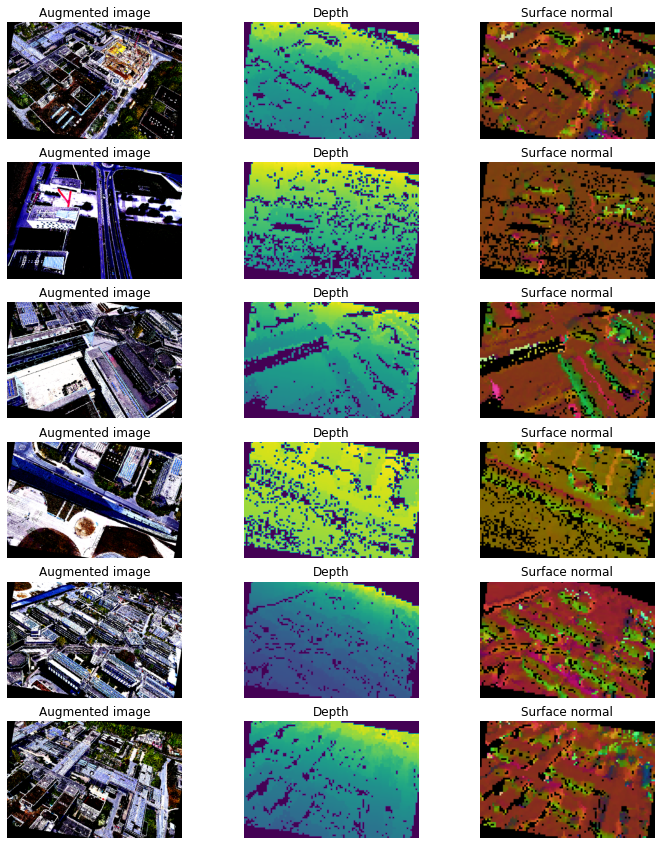

In [7]:
# Preview the datapoint
fig, axes = plt.subplots(6, 3, figsize=(12, 15))
for row in range(6):
    for ax in axes[row]:
        ax.axis('off')
    img = things[0][row].numpy().transpose(1, 2, 0)
#     img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)
    axes[row][0].imshow(img)
    axes[row][0].set_title("Augmented image")
    axes[row][1].imshow(things[2]['depth'][row, 0].numpy())
    axes[row][1].set_title("Depth")

    normal = things[2]['normal'][row].numpy().transpose(1, 2, 0).copy()
    normal += 1
    normal[np.sum(normal, axis=-1)!=-3] /= 2
    normal[np.sum(normal, axis=-1)!=-3] *= 255
    axes[row][2].imshow(normal.astype(np.uint8))
    axes[row][2].set_title("Surface normal")

for idx, filename in enumerate(things[4]):
    print("Idx: {:d}, filename: {:s}".format(idx, filename))